In [1]:
import pandas as pd
import numpy as np
import matplotlib

In [2]:
# Loading mapping files
mapping_to_token = pd.read_csv("../csv_files/steve_csv/mapping_token.csv")
mapping_to_ast = pd.read_csv("../csv_files/steve_csv/mapping_ast.csv")
mapping_to_rel_ast = pd.read_csv("../csv_files/steve_csv/mapping_relative_ast.csv")
mapping_to_comp_sort_ast = pd.read_csv("../csv_files/steve_csv/mapping_sorted_comp_ast.csv")

mapping = {"token" : mapping_to_token, "ast" : mapping_to_ast, "relative_ast" : mapping_to_rel_ast, "comp_sorted_ast" : mapping_to_comp_sort_ast}

d_type = {"commit_hash" : "str", 	"num_additions" : int,	"num_deletions": int, "filename" : "str"}

# Function for loading data
def load_data(file):
    df = pd.read_csv(file)
    df = df[df.filename.str.endswith(".java")]
    return pd.DataFrame({"commit_hash": df.commit_hash, "changes": pd.to_numeric(df.num_additions) + pd.to_numeric(df.num_deletions)})

# Loading data
data_java = load_data("../csv_files/steve_csv/output_java.csv")
data_java_nws = load_data("../csv_files/steve_csv/output_nws.csv") 
data_token = load_data("../csv_files/steve_csv/output_token.csv")
data_ast = load_data("../csv_files/steve_csv/output_ast.csv")
data_comp_sort_ast = load_data("../csv_files/steve_csv/output_sort_comp_ast.csv")
data_rel_ast = load_data("../csv_files/steve_csv/output_relative_ast.csv")

data = {"java" : data_java, "java_nws" : data_java_nws, "token" : data_token, "ast" : data_ast, "comp_sort_ast" : data_comp_sort_ast,"relative_ast" : data_rel_ast}

In [3]:
# Setting up dataframes
df_java = data_java.groupby('commit_hash').sum()
df_java_nws = data_java_nws.groupby('commit_hash').sum()
df_token = pd.merge(data_token, mapping_to_token, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_token"}).drop(columns=["to", "commit_hash_token"]).groupby('commit_hash').sum()
df_ast = pd.merge(data_ast, mapping_to_ast, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_ast"}).drop(columns=["to", "commit_hash_ast"]).groupby('commit_hash').sum()
df_sort_comp_ast = pd.merge(data_comp_sort_ast, mapping_to_comp_sort_ast, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_comp_ast"}).drop(columns=["to", "commit_hash_comp_ast"]).groupby('commit_hash').sum()
df_rel_ast = pd.merge(data_rel_ast, mapping_to_rel_ast, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_rel_ast"}).drop(columns=["to", "commit_hash_rel_ast"]).groupby('commit_hash').sum()

dfs = {"java" : df_java, "java_nws" : df_java_nws, "token" : df_token, "ast" : df_ast, "sort_comp_ast" : df_sort_comp_ast, "relative_ast" : df_rel_ast}

In [4]:
def mergeall(**dfs):
    items = dfs.items()
    table = df_java.rename(columns = dict(changes="repo"))
    for key, df in items:
        table = pd.merge(table, df.rename(columns = dict(changes=key)), left_index=True, right_index=True, validate="1:1", how="outer")
    return table

df_merged = mergeall(nws = df_java_nws, token = df_token, ast = df_ast, sorted_comp_ast = df_sort_comp_ast, relative_ast = df_rel_ast).fillna(0, downcast="int64")

df_merged.isna().sum()
df_merged

,repo,nws,token,ast,sorted_comp_ast,relative_ast
commit_hash,,,,,,
00083d13d83f7f0ea017aa32c8cf7596ea765ccc,19,19,50,120,57,78
013ebc5201879fed02a9039a8872b81b05a45c36,8,6,20,1247,33,47
018a3b846deb448af0a52d09bba57ad07e143c37,11,11,49,387,30,85
02a3e2119c07e693c4afd89da21d5b68eb7132b8,9,9,20,553,69,37
02fcf52f1b95ad944f40a1ba2938d1672f2ef05a,5102,5102,5102,116836,5698,5662
...,...,...,...,...,...,...
feb2ae2b64517eab2dc069672798ba8be3bd60e9,253,247,1077,6497,690,1627
fec2db748bc092b99f80238c4be417563b0fa101,136,134,1144,1771,528,1817
fec64b89f3bd68a0248ce6c940995ac11fedb272,174,174,836,2861,517,1277


<Axes: >

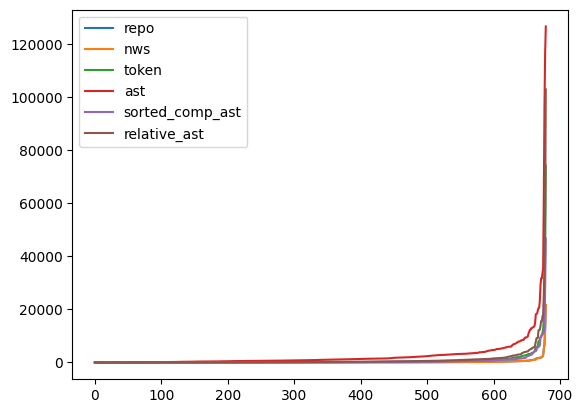

In [5]:
df = pd.DataFrame({k : np.array(df_merged[k].sort_values()) for k in df_merged.columns})
df.plot()

<Axes: >

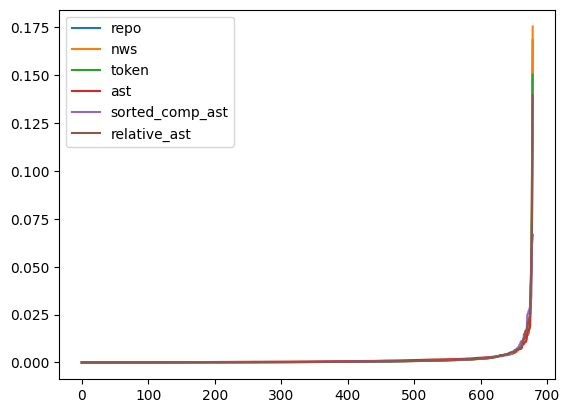

In [6]:
(df / df.sum()).plot()

In [7]:
df

,repo,nws,token,ast,sorted_comp_ast,relative_ast
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,2,4,2
3,1,0,1,2,6,2
4,1,1,2,2,7,2
...,...,...,...,...,...,...
674,2766,2674,12591,35678,11090,18085
675,5102,5102,16757,62609,11124,25790
676,6784,6784,25364,96036,13169,35678
677,12654,12642,39860,116836,27455,56169


<Axes: >

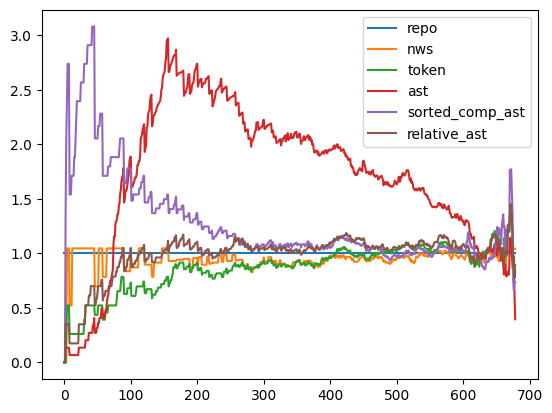

In [8]:
m = df.sum()
dt = df/m
dt.div(dt.repo, axis=0).plot()

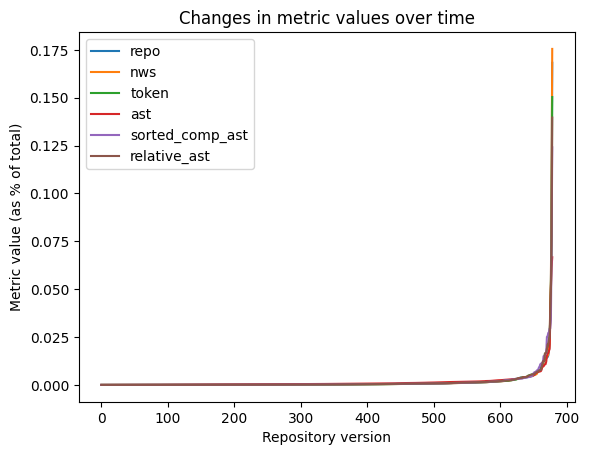

In [9]:
import matplotlib.pyplot as plt

(df[['repo','nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']] / df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']].sum()).plot(kind='line')
plt.xlabel('Repository version')
plt.ylabel('Metric value (as % of total)')
plt.title('Changes in metric values over time')
plt.show()


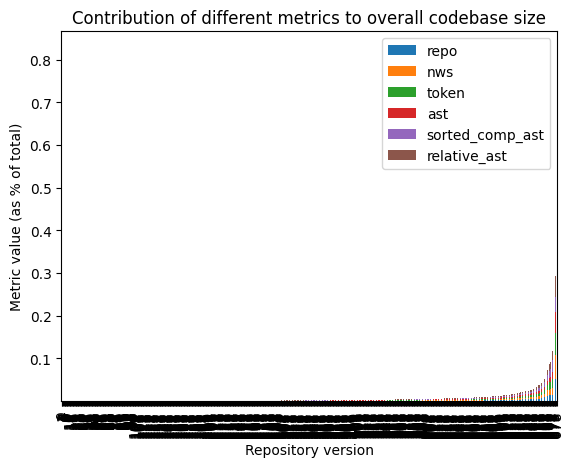

In [10]:
import matplotlib.pyplot as plt

(df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']] / df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']].sum()).plot(kind='bar', stacked=True)
plt.xlabel('Repository version')
plt.ylabel('Metric value (as % of total)')
plt.title('Contribution of different metrics to overall codebase size')
plt.show()


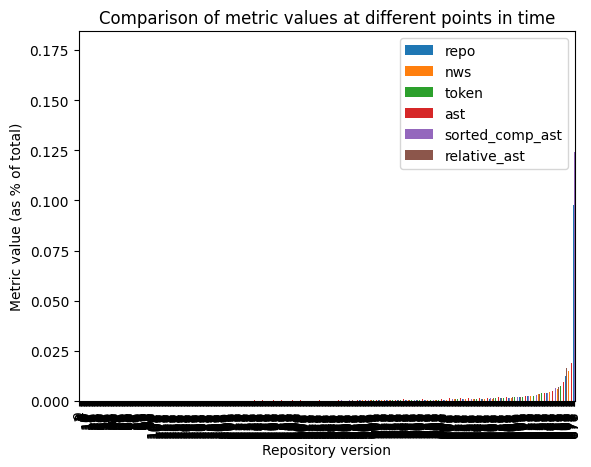

In [11]:
import matplotlib.pyplot as plt

(df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']] / df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']].sum()).plot(kind='bar')
plt.xlabel('Repository version')
plt.ylabel('Metric value (as % of total)')
plt.title('Comparison of metric values at different points in time')
plt.show()


<Axes: >

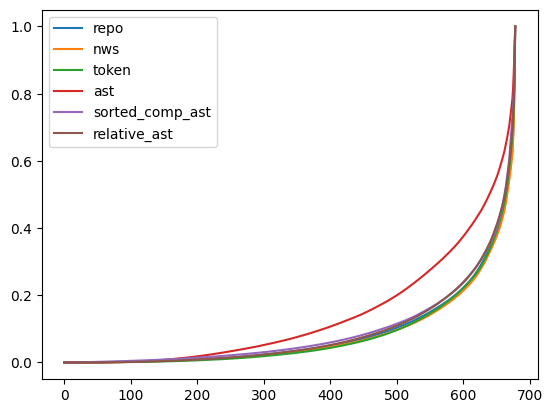

In [12]:
(df.cumsum() / df.sum()).plot()

<Axes: >

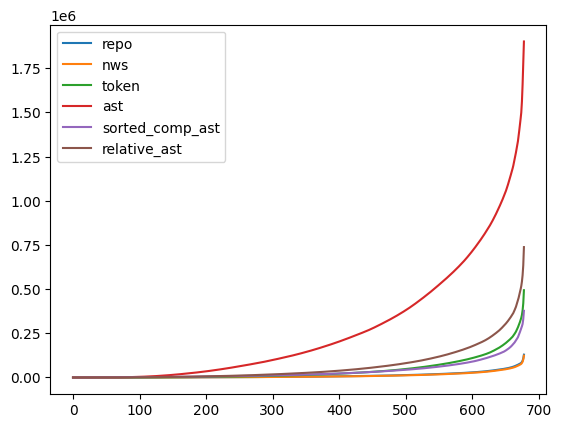

In [13]:
df.cumsum().plot()

In [14]:
#find størrelsen af filen for at finde en relativ ændring 
df_merged[df_merged.repo != 0][df_merged.nws == 0]

,repo,nws,token,ast,sorted_comp_ast,relative_ast
commit_hash,,,,,,
176ac0447b2e1f36f9a2ec7ad98381e5d0b22929,374,0,46,46,74,46
339e4f425c69021568eb7ed6d78d119272b6e7e4,18,0,0,0,0,0
70eecd6f6987d55ca114c0668068395033c8f5c0,2,0,2,2,34,2
83767338c31d8c05e81086c478cb104a74418f3a,464,0,0,136,192,136


In [15]:
df_merged / df_merged.sum()

,repo,nws,token,ast,sorted_comp_ast,relative_ast
commit_hash,,,,,,
00083d13d83f7f0ea017aa32c8cf7596ea765ccc,0.000147,0.000154,0.000101,0.000063,0.000151,0.000106
013ebc5201879fed02a9039a8872b81b05a45c36,0.000062,0.000049,0.000040,0.000656,0.000087,0.000064
018a3b846deb448af0a52d09bba57ad07e143c37,0.000085,0.000089,0.000099,0.000203,0.000079,0.000115
02a3e2119c07e693c4afd89da21d5b68eb7132b8,0.000070,0.000073,0.000040,0.000291,0.000183,0.000050
02fcf52f1b95ad944f40a1ba2938d1672f2ef05a,0.039486,0.041319,0.010331,0.061436,0.015099,0.007673
...,...,...,...,...,...,...
feb2ae2b64517eab2dc069672798ba8be3bd60e9,0.001958,0.002000,0.002181,0.003416,0.001828,0.002205
fec2db748bc092b99f80238c4be417563b0fa101,0.001053,0.001085,0.002316,0.000931,0.001399,0.002462
fec64b89f3bd68a0248ce6c940995ac11fedb272,0.001347,0.001409,0.001693,0.001504,0.001370,0.001731
